In [ ]:
!pip install rdkit-pypi

In [ ]:
!pip install --pre deepchem

In [ ]:
!pip install --pre dgl

In [ ]:
!pip install --pre dgllife

In [ ]:
!pip install --pre torch

In [ ]:
# example from class source
""""
.. [1] Zhaoping Xiong, Dingyan Wang, Xiaohong Liu, Feisheng Zhong, Xiaozhe Wan, Xutong Li,
         Zhaojun Li, Xiaomin Luo, Kaixian Chen, Hualiang Jiang, and Mingyue Zheng. "Pushing
         the Boundaries of Molecular Representation for Drug Discovery with the Graph Attention
         Mechanism." Journal of Medicinal Chemistry. 2020, 63, 16, 8749–8760.
         https://github.com/deepchem/deepchem/blob/master/deepchem/models/torch_models/attentivefp.py
""""
import deepchem as dc
import dgl
from deepchem.models import AttentiveFP
smiles = ["C1CCC1", "C1=CC=CN=C1"]
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
graphs = featurizer.featurize(smiles)
print(type(graphs[0]))
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
graphs = featurizer.featurize(smiles)
print(type(graphs[0]))
dgl_graphs = [graphs[i].to_dgl_graph(self_loop=True) for i in range(len(graphs))]
batch_dgl_graph = dgl.batch(dgl_graphs)
model = AttentiveFP(n_tasks=1, mode='regression')
preds = model(batch_dgl_graph)
print(type(preds))

In [220]:
# example from class source
import deepchem as dc
from deepchem.models import AttentiveFPModel
# preparing dataset
smiles = ["C1CCC1", "C1=CC=CN=C1", "CCC"]
labels = [0., 1., 0.]
featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
X = featurizer.featurize(smiles)
dataset = dc.data.NumpyDataset(X=X, y=labels)
# training model
model = AttentiveFPModel(mode='classification', n_tasks=1, batch_size=16, learning_rate=0.001)
loss = model.fit(dataset, nb_epoch=5)
loss

/Users/kls395/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


0.0933565378189087

In [221]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole #Needed to show molecules
from rdkit.Chem.Draw.MolDrawing import MolDrawing, DrawingOptions #Only needed if modifying defaults
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw


# read sdf file with structures before docking
input = Chem.SDMolSupplier('All_input_structures.sdf')

inputs = []

for x in input:
    y=Chem.Mol(x) # use constructor to copy not just reference
    AllChem.Compute2DCoords(y)
    inputs.append(y)
print(len(input))


1116


/Users/kls395/opt/anaconda3/lib/python3.8/site-packages/rdkit/Chem/Draw/IPythonConsole.py:241: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


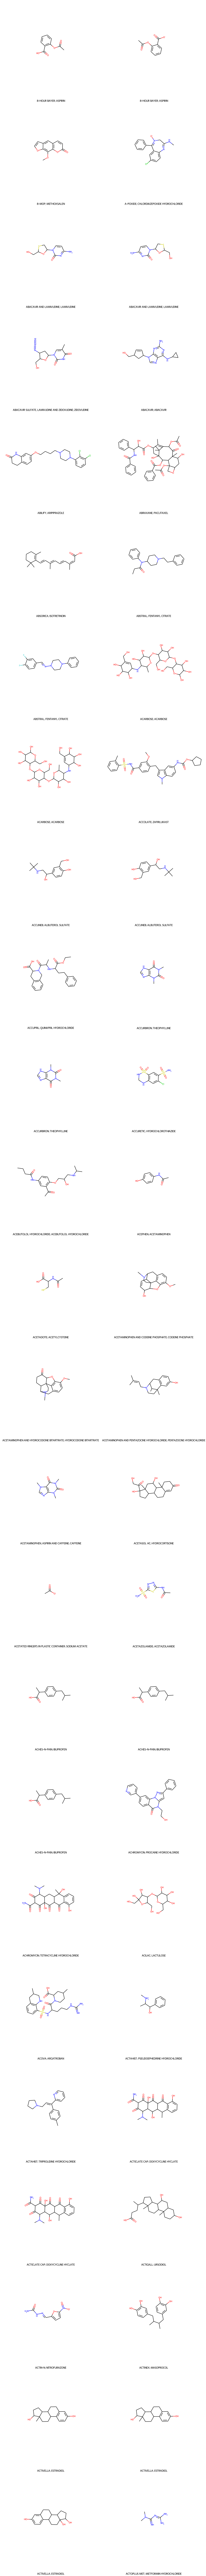

In [222]:
# draw multi mol sdf in 2D
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

Draw.MolsToGridImage(inputs,molsPerRow=2,subImgSize=(600,600),legends=[x.GetProp("FDA drugnames") for x in inputs]) 


In [ ]:
list(mols[0].GetPropNames()) # List propoeties off molecules docked

In [223]:
# Read sdf's from Simone with docked structures
from rdkit import Chem
from rdkit.Chem import AllChem

def unique(list):
 
    # initialize a null list
    unique_list_prop = []
    unique_list = [] 
    # traverse for all elements
    for x in list:
        # check if same compound in docked in same grid exists in unique_list or not
        test = x.GetProp("FDA drugnames")+x.GetProp('s_i_glide_gridfile')
        if test not in unique_list_prop:
            unique_list_prop.append(test)
            unique_list.append(x)
    return unique_list 


# read sdf file
suppl = Chem.SDMolSupplier('All_proteins_total.sdf')

# list of deepchem mols as list of pointers to suppl
mols = [x for x in suppl]
print(" Total number of FDA drug conformations successfully docked: " + str(len(mols)))

# get unique drugs and assuming lowest energy conformation first
mols2 = unique(mols)
print(" Number of FDA drugs successfully docked: " + str(len(mols2)))

 Total number of FDA drug conformations successfully docked: 30861
 Number of FDA drugs successfully docked: 10151


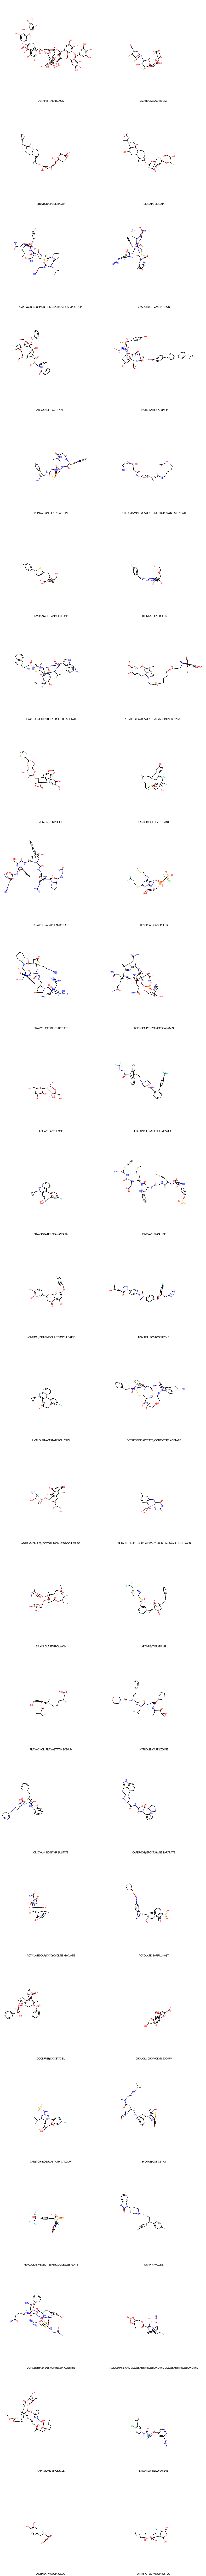

In [209]:
# Draw docked conformations
Draw.MolsToGridImage(mols2,molsPerRow=2,subImgSize=(600,600),legends=[x.GetProp("FDA drugnames") for x in mols2]) 


In [210]:
# Transform data for NN input using panda dataframe

import pandas as pd
import numpy as np

mollist = [] # list of docked mol objects for featurization

for mol in mols2:
    mollist.append([mol.GetProp('s_i_glide_gridfile'), mol.GetProp("FDA drugnames"), float(mol.GetProp('r_i_glide_gscore')), mol])
#

df = pd.DataFrame.from_records(mollist) # import to dataframe

df = df.pivot(index=1, columns=0, values=[2,3]) # convert to pivot table with drugs as index, docking grids as coloums and docking scores and mols as values

# rename columns so not multiindexed
receptors = []
for rec in df.keys():
    receptors.append(rec[1][11:15])
no_receptors = int(len(receptors)/2)
receptor_scores = []

# add mol designator to the molecule rows
for i in range(len(receptors)):
    if i >= no_receptors:
        receptors[i] = receptors[i] + "_mol"
    else:
        receptor_scores.append(receptors[i])
        
df.columns = receptors

# convert docking scores to float and round
for rec in receptor_scores:
    df[rec] = pd.to_numeric(df[rec]).round(1)

# change Nan to zero everywhere
df = df.fillna(0)
#df.replace(np.nan,0)

# export from dataframe to lists as numpy array initializers
# first the mol objects. Just use results from from one receptor as we do not use 3D conformations for graphs
docked_mols = df[('MRP8_mol')].values.tolist()
# ugly hack as mol 551 is missing from the otherwise most complete MRP8 docking dataset, so take it from the MRP2 dataset
docked_mols[551] = df[('MRP2_mol')][551]

# second, slice out docking scores (y values) from dataframe and put in numpy array
y_values = np.array(df.iloc[0:, :no_receptors], dtype=np.float64)


# Export docking scores from dataframe to excel
df_scores = df.iloc[0:, :no_receptors]
df_scores.to_excel("docking_scores.xlsx")


In [ ]:
# Draw docked conformations
Draw.MolsToGridImage(docked_mols,molsPerRow=2,subImgSize=(600,600),legends=[x.GetProp("FDA drugnames") for x in docked_mols]) 


In [211]:
# start data analysis

# print best docked mol for each receptor

best = []

for col in receptor_scores:
    column = df[col]
    min_value = column.min()
    min_index = column.idxmin()
    best.append([col, min_index, min_value])

df_best = pd.DataFrame(best)

df_best.columns = ["Receptor", "Drug", "Docking score"]

df_best

,Receptor,Drug,Docking score
0,BCRP,SYNAREL; NAFARELIN ACETATE,-15.6
1,MDR1,DEPINAR; TANNIC ACID,-24.0
2,MRP1,DEPINAR; TANNIC ACID,-24.2
3,MRP2,DEPINAR; TANNIC ACID,-26.1
4,MRP3,DEPINAR; TANNIC ACID,-25.9
5,MRP4,DEPINAR; TANNIC ACID,-21.5
6,MRP5,DEPINAR; TANNIC ACID,-27.4
7,MRP6,DEPINAR; TANNIC ACID,-21.6
8,MRP7,DEPINAR; TANNIC ACID,-19.0
9,MRP8,DEPINAR; TANNIC ACID,-22.2


In [212]:
# set threshold docking score for analysis and create dataframe with these

def _color_red_or_green(val):
    color = 'red' if val > -14 else 'green'
    return 'color: %s' % color


min_score =-14

df_highscore = df[(df_scores < min_score).any(1)]
# set docking score for those not docked (score NaN) to 0 
df_highscore.fillna(0)
#df_highscore.replace(np.nan,0)
#df_highscore



d = dict.fromkeys(df.select_dtypes('float').columns, "{:.1f}")
df3 = df_highscore.iloc[0:, :no_receptors].style.applymap(_color_red_or_green).format(d)

# extract mols with docking score better than minscore to a list for plotting

lst_minscore =[]

for i, row in df_highscore.iterrows():
    for j, col in row.iteritems():
        if isinstance(col, float):
            if col < min_score:
                lst_minscore.append(df_highscore.loc[i].at[str(j) + "_mol"])
df3

,BCRP,MDR1,MRP1,MRP2,MRP3,MRP4,MRP5,MRP6,MRP7,MRP8,MRP9
1,,,,,,,,,,,
ACARBOSE; ACARBOSE,-14.4,-13.8,-16.2,-13.2,-14.1,-14.7,-13.1,-13.9,-13.5,-11.3,-12.9
CROLOM; CROMOLYN SODIUM,-10.0,-11.0,-8.7,-7.5,-6.9,-9.6,-14.8,-4.3,-3.5,-4.3,-9.2
DEPINAR; TANNIC ACID,0.0,-24.0,-24.2,-26.1,-25.9,-21.5,-27.4,-21.6,-19.0,-22.2,0.0
KENGREAL; CANGRELOR,-11.3,-11.4,-9.8,-10.0,-8.9,-12.0,-14.7,-9.3,-7.8,-9.9,-14.5
KINEVAC; SINCALIDE,-11.8,-9.6,-9.3,-9.9,-9.4,-10.9,-17.9,-8.7,-8.3,-12.6,-8.8
OTREXUP; METHOTREXATE,-7.9,-9.5,-7.9,-7.6,-8.0,-9.0,-14.1,-6.8,-8.4,-6.6,-9.1
PEPTAVLON; PENTAGASTRIN,-11.7,-11.0,-10.5,-12.9,-12.1,-11.4,-16.4,-10.4,-10.4,-11.0,-12.9
SYNAREL; NAFARELIN ACETATE,-15.6,-9.1,-10.6,-10.6,-12.1,-13.6,-9.7,-9.5,-12.2,-14.8,-7.8


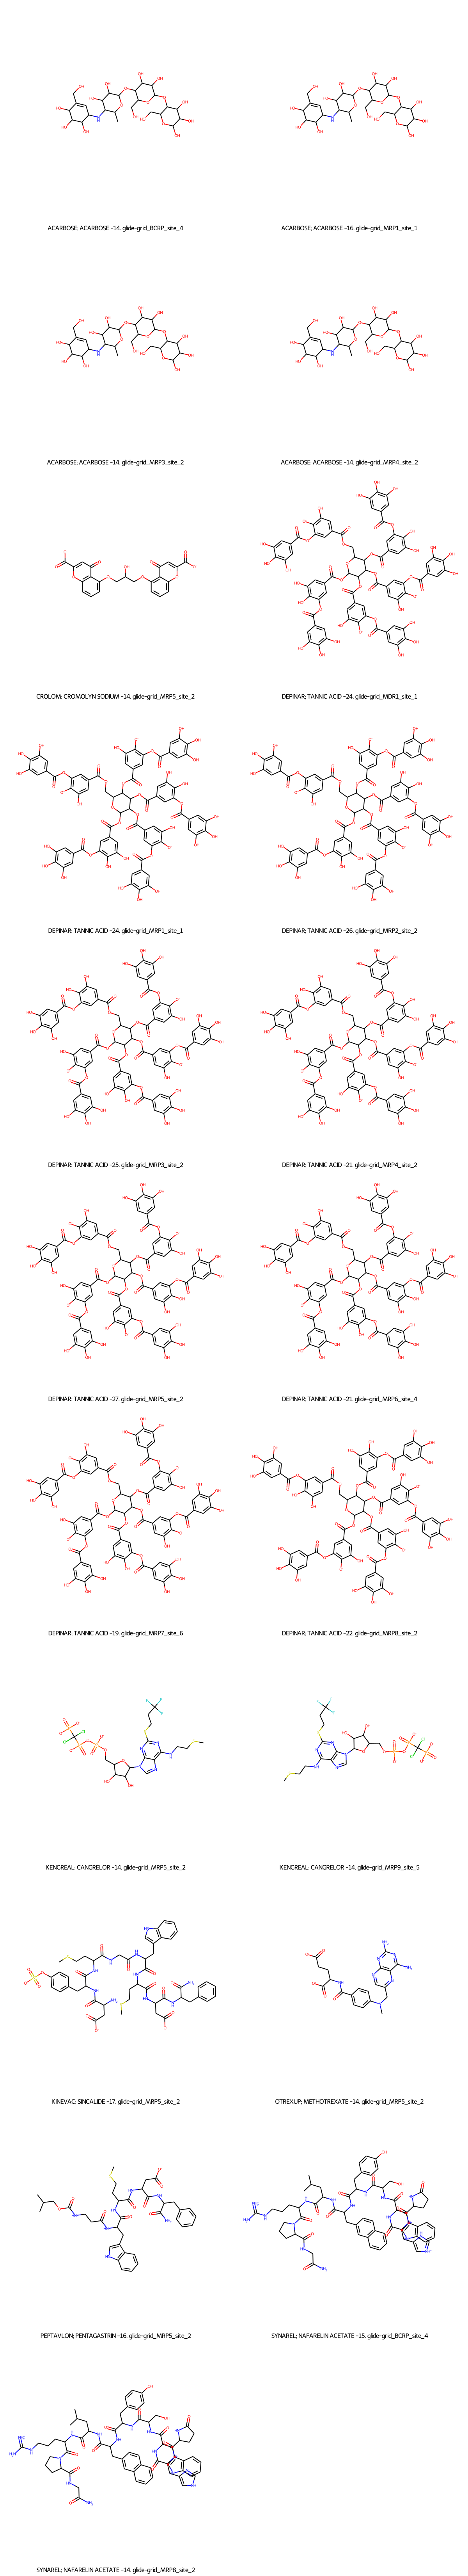

In [224]:
# make gridplot with mols docking better than threshold. Convert to 2D as #D plots get very small. Why is ToDo

pltmol = []

for x in lst_minscore:
    y=Chem.Mol(x) # use constructor to copy not just reference
    AllChem.Compute2DCoords(y)
    pltmol.append(y)

Draw.MolsToGridImage(pltmol,molsPerRow=2,subImgSize=(600,600),legends=[x.GetProp("FDA drugnames") + " " + str(x.GetProp('r_i_glide_gscore')[:4])  + " " + x.GetProp('s_i_glide_gridfile') for x in pltmol]) 


In [225]:
# Featurize with molgraphconv
import numpy as np
from deepchem.feat import MolGraphConvFeaturizer

#featurizer = dc.feat.graph_features.ConvMolFeaturizer()
featurizer = MolGraphConvFeaturizer(use_edges=True)

X = featurizer.featurize(docked_mols)

In [ ]:
# Featurize with Coulombmatrix
# Does not work yet
import deepchem as dc
featurizers = dc.feat.CoulombMatrix(max_atoms=200)
input_file = 'mrp4_total.sdf' # really backed by water.sdf.csv
tasks = ["r_i_glide_gscore"]
loader = dc.data.SDFLoader(tasks, featurizer=featurizers)
dataset_cou = loader.create_dataset(input_file)

from deepchem.models import DTNNModel
# training model
model = DTNNModel(n_tasks=1, n_embedding=200)
model.default_generator(dataset_cou, epochs=1, mode='fit', deterministic=True, pad_batches=True)
#model.fit(dataset_cou, nb_epoch=10)

In [226]:
#Create dataset for deepchem

import deepchem as dc

dataset = dc.data.NumpyDataset(X=X, y=y_values)


In [216]:
# Split dataset into train, validation and test datasets

splitter = dc.splits.RandomSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(
  dataset=dataset, frac_train=0.6, frac_valid=0.2, frac_test=0.2)

len(test_dataset)

187

In [217]:
import deepchem as dc
from deepchem.models import AttentiveFPModel
no_receptors = 11 # Should be extracted from sd dataset. ToDo
# training model
model = AttentiveFPModel(mode='regression', n_tasks=no_receptors, batch_size=16, learning_rate=0.001)

loss = model.fit(train_dataset, nb_epoch=100)
loss

/Users/kls395/opt/anaconda3/lib/python3.8/site-packages/torch/autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


0.31114879608154294

In [ ]:
dir(model)

In [218]:
metric = dc.metrics.Metric(dc.metrics.r2_score)
print('Training set score:', model.evaluate(train_dataset, [metric]))
print('Test set score:', model.evaluate(test_dataset, [metric]))
print('Validation set score:', model.evaluate(valid_dataset, [metric]))


Training set score: {'r2_score': 0.9238981912287219}
Test set score: {'r2_score': 0.32980763182640493}
Validation set score: {'r2_score': 0.426230207116731}


In [219]:
# predict from smiles string
X_predict = featurizer.featurize("CCCCCC")
dataset_predict = dc.data.NumpyDataset(X=X_predict)
model.predict(dataset_predict)

array([[-2.7817194 , -1.9852676 , -2.1910098 , -0.64831764, -2.0437605 ,
        -1.1134313 , -0.99516153, -1.6181002 , -1.5043306 , -0.5361182 ,
        -1.5313058 ]], dtype=float32)